<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Day-14-:-Disk-defragmentation" data-toc-modified-id="Day-14-:-Disk-defragmentation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Day 14 : Disk defragmentation</a></span><ul class="toc-item"><li><span><a href="#Part-One" data-toc-modified-id="Part-One-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Part One</a></span></li><li><span><a href="#Part-Two:" data-toc-modified-id="Part-Two:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Part Two:</a></span></li></ul></li></ul></div>

## Day 14 : Disk defragmentation

A few imports...

In [1]:
from knothash import hash_as_hexa
import numpy as np
import PIL
from PIL import Image, ImageDraw
from queue import Queue
from IPython import display
import random

### Part One

In [2]:
assert hash_as_hexa('AoC 2017') == '33efeb34ea91902bb2f59c9920caa6cd'

In [3]:
def hash_to_bin_array(h):
    b = int(h, 16)
    s = bin(b)[2:]  # remove the binary prefix
    if len(s) < 128:
        s = '0' * (128-len(s)) + s
    return np.array([
        int(c) for c in s
        ])
    

In [4]:
def get_rows(key):
    result = []
    for i in range(128):
        k = '{}-{}'.format(key, i)
        h = hash_as_hexa(k) 
        result.append(hash_to_bin_array(h))
    return np.array(result)

rows = get_rows('flqrgnkx')
print(rows)

[[1 1 0 ..., 1 1 0]
 [0 1 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 1]
 ..., 
 [1 1 1 ..., 1 0 0]
 [1 1 0 ..., 1 0 1]
 [0 0 1 ..., 1 1 0]]


In [5]:
def show_memory(mm):
    rows, cols = mm.shape
    buff = []
    for row in range(rows):
        for col in range(cols):
            buff.append('.' if mm[row][col] == 0 else '#')
        buff.append('\n')
    return ''.join(buff)

print(show_memory(rows[0:12,0:12]))

##.#.#..####
.#.#.#.####.
....#.#.##.#
#.#.##.#..##
.##.#.....#.
##..#..#####
.#...#..##..
##.#.##..###
####.######.
##.#.####...
...#....#.##
.###########



In [6]:
rows = get_rows('xlqgujun')
print('Part one:', sum(sum(rows)))

Part one: 8204


### Part Two:

In [7]:
def draw_map(m):
    rows, cols = m.shape
    size = (cols*6+1, rows*6+1)
    im = Image.new('RGB', size, color='#336699')
    draw = ImageDraw.Draw(im)
    for row, data in enumerate(m):
        for col, bit in enumerate(data):
            x = col * 6 + 1
            y = row * 6 + 1
            rect = (x, y, x+4, y+4)
            if bit == 1:
                draw.rectangle(rect, fill='red')
            elif bit == 0:
                draw.rectangle(rect, fill='#6699cc')
            else:
                draw.rectangle(rect, fill='green')
    del draw
    return im

In [8]:
test_map = np.array([
    [1, 1, 0, 1],
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [1, 1, 1, 0],
])

draw_map(test_map)

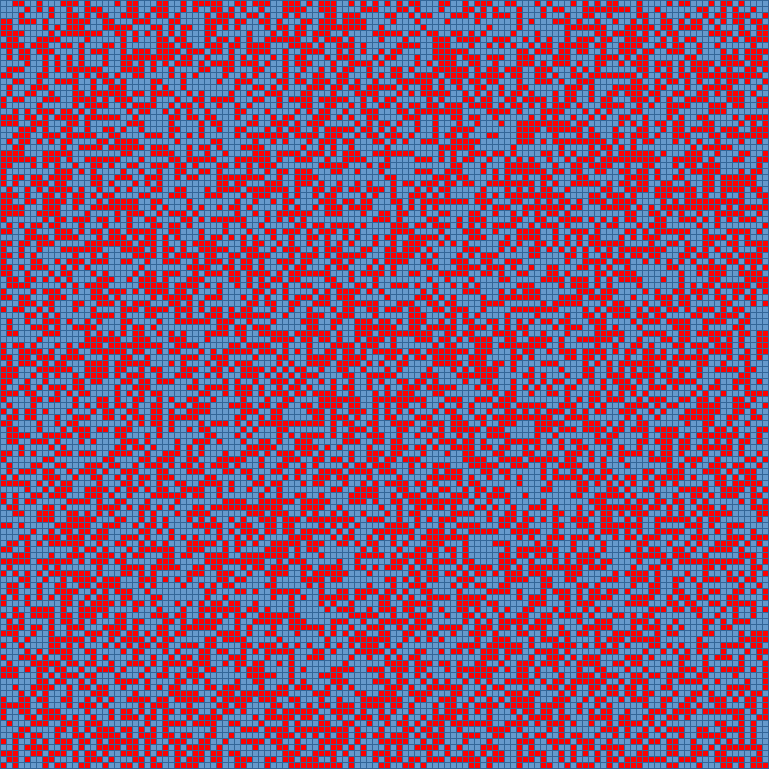

In [9]:
draw_map(rows)

In [10]:
def filter_sector(rows, row, col):
    max_rows, max_cols = rows.shape
    if all([ 0 <= row < max_rows, 0 <= col < max_cols]):
        return (row, col)
    else:
        return None
    

def adjacents(rows, row, col):
    all = [
        filter_sector(rows, row,   col-1),
        filter_sector(rows, row-1, col),
        filter_sector(rows, row+1, col),
        filter_sector(rows, row,   col+1),
        ]
    return set([v for v in all if v is not None])


def get_values(rows, list_of_coords):
    return set([rows[row][col] for (row, col) in list_of_coords])

# tests

test_map = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
    ])

assert get_values(test_map, adjacents(test_map, 0, 0)) == set([2,4])
assert get_values(test_map, adjacents(test_map, 0, 1)) == set([1, 3, 5])
assert get_values(test_map, adjacents(test_map, 0, 2)) == set([2, 6])

assert get_values(test_map, adjacents(test_map, 1, 0)) == set([1, 5, 7])
assert get_values(test_map, adjacents(test_map, 1, 1)) == set([2, 4, 6, 8])
assert get_values(test_map, adjacents(test_map, 1, 2)) == set([3, 5, 9])

assert get_values(test_map, adjacents(test_map, 2, 0)) == set([4, 8])
assert get_values(test_map, adjacents(test_map, 2, 1)) == set([5, 7, 9])
assert get_values(test_map, adjacents(test_map, 2, 2)) == set([8, 6])


In [11]:
test_map = np.array([
    [0, 1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 1, 0, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 0]
    ])

def find_group(m, row, col):
    value = m[row][col]
    if value == 0:
        return None
    start = (row, col)
    frontier = Queue()
    frontier.put(start)
    group = set()
    while not frontier.empty():
        r, c = frontier.get()
        group.add((r, c))
        for rn, cn in adjacents(m, r, c):
            value = m[rn][cn]
            if value == 1:
                if (rn,cn) not in group:
                    frontier.put((rn,cn))
                group.add((rn,cn))
    return (start, group)
    
id_group, nodes = find_group(test_map, 0, 1)

assert id_group == (0, 1)
assert len(nodes) == 29
print(sorted(nodes), len(nodes))

[(0, 1), (0, 2), (0, 3), (0, 5), (1, 2), (1, 5), (1, 6), (1, 7), (2, 2), (2, 3), (2, 5), (2, 7), (2, 8), (3, 2), (3, 3), (3, 4), (3, 5), (3, 8), (4, 2), (4, 3), (4, 4), (4, 8), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7)] 29


In [12]:
test_map = np.array([
    [1, 1, 0, 1],
    [1, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [1, 1, 1, 0],
])


def find_groups(m):
    rows, cols = m.shape
    seen = set()
    result = dict()
    for row in range(rows):
        for col in range(cols):
            if (row, col) in seen:
                continue
            g = find_group(m, row, col)
            if g:
                (id_group, nodes) = g
                result[id_group] = nodes
                seen.update(nodes)
    return result

find_groups(test_map)

{(0, 0): {(0, 0), (0, 1), (1, 0)},
 (0, 3): {(0, 3), (1, 3)},
 (2, 2): {(2, 2), (3, 2), (4, 0), (4, 1), (4, 2)}}

In [13]:
def get_random_color():
    red = '00{:x}'.format(random.randrange(32, 256))[-2:]
    green = '00{:x}'.format(random.randrange(32, 256))[-2:]
    blue = '00{:x}'.format(random.randrange(32, 256))[-2:]
    
    return '#{}{}{}'.format(red, green, blue)

def draw_color_map(m):
    rows, cols = m.shape
    size = (cols*6+1, rows*6+1)
    im = Image.new('RGB', size, color='#336699')
    draw = ImageDraw.Draw(im)
    for row, data in enumerate(m):
        for col, bit in enumerate(data):
            x = col * 6 + 1
            y = row * 6 + 1
            rect = (x, y, x+4, y+4)
            color = str(m[row][col])
            draw.rectangle(rect, fill=color or '#000000')
    del draw
    return im

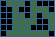

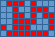

In [14]:
test_map = np.array([
    [0, 1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 1, 0, 0, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 0]
    ])

group = find_group(test_map, 0, 1)
color_map = np.empty_like(test_map, dtype='U7')
k, nodes = group
color = get_random_color()
for (r, c) in nodes:
    color_map[r][c] = color
display.display(draw_color_map(color_map))
display.display(draw_map(test_map))



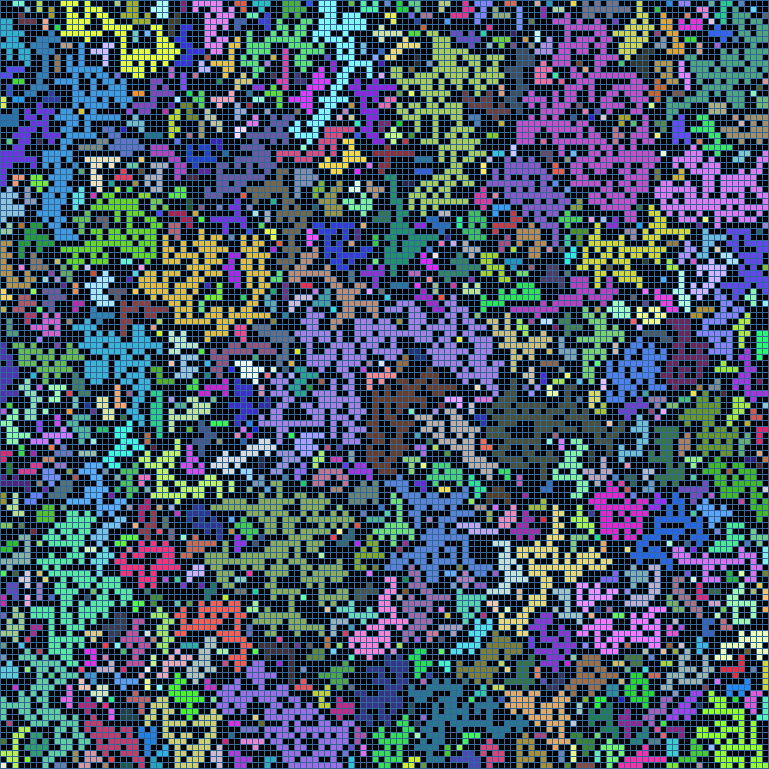

In [15]:
rows = get_rows('xlqgujun')
color_map = np.empty_like(rows, dtype='U7')
groups = find_groups(rows)
for k in groups:
    color = get_random_color()
    for (r, c) in groups[k]:
        color_map[r][c] = color
draw_color_map(color_map)        

In [16]:
print('Part 2:', len(groups))

Part 2: 1089
